In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset
import torch
from sklearn.metrics import max_error,mean_squared_error

In [2]:
def data_preprocess(data,steps=61,train=True):
    past_values=[]
    past_time_features=[]
    past_observed_mask=[]
    static_categorical_features=[]
    static_real_features=[]
    future_values=[]
    future_time_features=[]
    for line in tqdm(range(len(data)-steps)):
        date,weekday,mon=data[['date','weekday','mon']].iloc[line+steps].values.tolist()
        past_value=data['num'].iloc[line:line+steps-1].tolist()
        past_values.append(past_value)
        past_time_features=data[['weekday','mon','day']].iloc[line:line+steps-1].values.tolist()
        past_time_features.append(past_time_feature)
        past_observed_mask.append([1]*(steps-1))
        static_categorical_feature=[0]
        static_categorical_features.append(static_categorical_feature)
        static_real_features.append([0])
        future_value=[data['num'].iloc[line+steps]]
        future_values.append(future_value)
        future_time_feature=data[['weekday','mon','day']].iloc[line+steps].values.tolist()
        future_time_features.append(['future_time_feature'])
        return {'past_values':past_values,
                 'past_time_features':past_time_features,
                 'past_observed_mask':past_observed_mask,
                 'static_categorical_features':static_categorical_features,
                 'static_real_features':static_real_features,
                 'future_values':future_values,
                 'future_time_features':future_time_features}

In [ ]:
class Time_series_Dataset(Dataset):
    def __init__(self,example_list):
        self.past_values=example_list['past_values']
        self.past_time_features=example_list['past_time_features']
        self.past_observed_mask=example_list['past_observed_mask']
        self.static_categorical_features=example_list['static_categorical_features']
        self.static_real_features=example_list['static_real_features']
        self.future_values=example_list['future_values']
        self.future_time_features=example_list['future_time_features']
    def __len__(self):
        return len(self.past_values)
    def __getitem__(self,idx):
        past_values=self.past_values[idx]
        past_time_features=self.past_time_features[idx]
        past_observed_mask=self.past_observed_mask[idx]
        static_categorical_features=self.static_categorical_features[idx]
        static_real_features=self.static_real_features[idx]
        future_values=self.future_values[idx]
        future_time_features=self.future_time_features[idx]
        return {'past_values':torch.tensor(past_values,dtype=torch.float32),
                'past_time_features':torch.tensor(past_time_features,dtype=torch.long),
                'past_observed_mask':torch.tensor(past_observed_mask,dtype=torch.long),
                 'static_categorical_features':torch.tensor(static_categorical_features,dtype=torch.long),
                  'static_real_features':torch.tensor(static_real_features,dtype=torch.long),
                   'future_values':torch.tensor(future_values,dtype=torch.float32),
                    'future_time_features':torch.tensor(future_time_features,dtype=torch.long)}
def time_series_loader(example_list,batch_size,num_workers=8):
    ds=Time_series_Dataset(example_list=example_list)
    return DataLoader(ds,batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True)

In [3]:
from transformers import AdamW,get_linear_schedule_with_warmup

In [4]:
from transformers import TimeSeriesTransformerForPrediction,TimeSeriesTransformerConfig,TimeSeriesTransformerModel

In [7]:
config=TimeSeriesTransformerConfig(input_size=1,#单变量
                                   context_length=1,
                                   prediction_length=1,#预测期数
                                   loss='nll',
                                    distribution_output='normal',
                                    cardinality=[11,3],
                                     num_static_categorical_features=2,
                                     drop_out=0.3,
                                     num_dynamic_real_features=1,
                                     activation_function='gelu',
                                     embedding_dimension=[22,9],
                                     lags_sequence=[1,2,3,5,7,28,29,30,31,59],
                                     future_time_features=5,
                                     d_model=48,
                                     encoder_layers=16,
                                     decoder_layers=16,
                                     encoder_attention_header=12,
                                     decoder_attention_header=12,
                                     num_time_features=5,
                                     init_std=0.04
                                     )
model=TimeSeriesTransformerForPrediction(config)

In [9]:
epochs=300
optimizer=torch.optim.AdamW(model.parameters(),lr=1e-3)
total_steps=len(datas)*epochs
scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=init(0.05*total_steps),num_training_steps=total_steps)

In [ ]:
for k in range(epochs):
    model=model.train()
    for batch in datas:
        outputs=model(past_values=batch['past_values'],
                      past_time_features=batch['past_time_features'],
                      past_observed_mask=batch['past_observed_mask'],
                      static_categorical_features=batch['static_categorical_features'],
                      static_real_features=batch['static_real_features'],
                      future_values=batch['future_values'],
                      future_time_features=batch['future_time_features'])
    loss=outputs.loss
    losses=loss.tolist()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
    optimizer.step()
    scheduler.step()
    print(f'loss is {losses})
    prdiction=model.generate(past_values=batch['past_values'],
                      past_time_features=batch['past_time_features'],
                      past_observed_mask=batch['past_observed_mask'],
                      static_categorical_features=batch['static_categorical_features'],
                      static_real_features=batch['static_real_features'],
#                       future_values=batch['future_values'],
                      future_time_features=batch['future_time_features'])
    mean_prediction=prediction.sequences.mean(dim=1)
    Max_error=max_error(batch['future_values'].view(-1).tolist(),mean_prediction.view(-1).tolist())
    

In [1]:
from torch import nn
import math


def probsparse_attention(query_states, key_states, value_states, sampling_factor=5):
    """
    Compute the probsparse self-attention.
    Input shape: Batch x Time x Channel

    Note the additional `sampling_factor` input.
    """
    # get input sizes with logs
    L_K = key_states.size(1)
    L_Q = query_states.size(1)
    log_L_K = np.ceil(np.log1p(L_K)).astype("int").item()
    log_L_Q = np.ceil(np.log1p(L_Q)).astype("int").item()

    # calculate a subset of samples to slice from K and create Q_K_sample
    U_part = min(sampling_factor * L_Q * log_L_K, L_K)

    # create Q_K_sample (the q_i * k_j^T term in the sparsity measurement)
    index_sample = torch.randint(0, L_K, (U_part,))
    K_sample = key_states[:, index_sample, :]
    Q_K_sample = torch.bmm(query_states, K_sample.transpose(1, 2))

    # calculate the query sparsity measurement with Q_K_sample
    M = Q_K_sample.max(dim=-1)[0] - torch.div(Q_K_sample.sum(dim=-1), L_K)

    # calculate u to find the Top-u queries under the sparsity measurement
    u = min(sampling_factor * log_L_Q, L_Q)
    M_top = M.topk(u, sorted=False)[1]

    # calculate Q_reduce as query_states[:, M_top]
    dim_for_slice = torch.arange(query_states.size(0)).unsqueeze(-1)
    Q_reduce = query_states[dim_for_slice, M_top]  # size: c*log_L_Q x channel

    # and now, same as the canonical
    d_k = query_states.size(-1)
    attn_scores = torch.bmm(Q_reduce, key_states.transpose(-2, -1))  # Q_reduce x K^T
    attn_scores = attn_scores / math.sqrt(d_k)
    attn_probs = nn.functional.softmax(attn_scores, dim=-1)
    attn_output = torch.bmm(attn_probs, value_states)

    return attn_output, attn_scores


/oper/ch/env/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import nn

# ConvLayer is a class with forward pass applying ELU and MaxPool1d
def informer_encoder_forward(x_input, num_encoder_layers=3, distil=True):
    # Initialize the convolution layers
    if distil:
        conv_layers = nn.ModuleList([ConvLayer() for _ in range(num_encoder_layers - 1)])
        conv_layers.append(None)
    else:
        conv_layers = [None] * num_encoder_layers
    
    # Apply conv_layer between each encoder_layer
    for encoder_layer, conv_layer in zip(encoder_layers, conv_layers):
        output = encoder_layer(x_input)
        if conv_layer is not None:
            output = conv_layer(loutput)
    
    return output


In [3]:
from datasets import load_dataset


In [7]:
dataset = load_dataset("monash_tsf", "traffic_hourly")

Dataset monash_tsf downloaded and prepared to /home/device/.cache/huggingface/datasets/monash_tsf/traffic_hourly/1.0.0/82998723d55d6edbc664cfaebe371004d849846ee5f61b57f1f974000d44c050. Subsequent calls will reuse this data.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 692.82it/s]


In [5]:
import os 

In [6]:
proxy_ip='http://127.0.0.1:7891'
os.environ['http_proxy']=proxy_ip
os.environ['https_proxy']=proxy_ip

In [8]:
train_example = dataset["train"][0]
validation_example = dataset["validation"][0]

In [10]:
freq = "1H"
prediction_length = 48

assert len(train_example["target"]) + prediction_length == len(
    dataset["validation"][0]["target"])

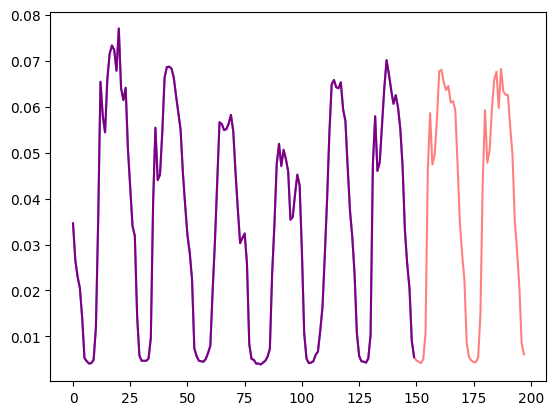

In [11]:
import matplotlib.pyplot as plt

num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    validation_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()


In [12]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [13]:
from functools import lru_cache

import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [14]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))


In [15]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)


In [16]:
multi_variate_train_example = multi_variate_train_dataset[0]
print('multi_variate_train_example["target"].shape =', multi_variate_train_example["target"].shape)

multi_variate_train_example["target"].shape = (862, 17448)


In [17]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [18]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x7f53d116e160>, <function day_of_week at 0x7f53d116e310>, <function day_of_month at 0x7f53d116e430>, <function day_of_year at 0x7f53d116e550>]


In [19]:
from pandas.core.arrays.period import period_array

timestamp = pd.Period("2015-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'hour_of_day': array([-0.45652174]), 'day_of_week': array([0.]), 'day_of_month': array([-0.5]), 'day_of_year': array([-0.5])}


In [20]:
from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)


In [21]:
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)


In [22]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [23]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [24]:
from typing import Iterable

from torch.utils.data import DataLoader

from gluonts.itertools import Cached, Cyclic, IterableSlice, PseudoShuffled
from gluonts.torch.util import IterableDataset


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train") + SelectFields(
        TRAINING_INPUT_NAMES
    )

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    training_instances = instance_splitter.apply(
        Cyclic(transformed_data)
        if shuffle_buffer_length is None
        else PseudoShuffled(
            Cyclic(transformed_data),
            shuffle_buffer_length=shuffle_buffer_length,
        )
    )

    # from the training instances iterator we now return a Dataloader which will
    # continue to sample random windows for as long as it is called
    # to return batch_size of the appropriate tensors ready for training!
    return IterableSlice(
        iter(
            DataLoader(
                IterableDataset(training_instances),
                batch_size=batch_size,
                **kwargs,
            )
        ),
        num_batches_per_epoch,
    )


In [25]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test") + SelectFields(
        PREDICTION_INPUT_NAMES
    )

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    # This returns a Dataloader which will go over the dataset once.
    return DataLoader(
        IterableDataset(testing_instances), batch_size=batch_size, **kwargs
    )


In [28]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)


In [29]:
batch = next(iter(train_dataloader))
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


In [30]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 25
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 1000 == 0:
            print(loss.item())

-1065.9217529296875
-2050.4287109375
-2452.80419921875
-2490.444091796875
-2454.920166015625
-2660.807861328125
-2610.5087890625
-2696.199951171875
-2729.6953125
-2701.33984375
-2760.893798828125
-2776.651611328125
-2682.222412109375
-2795.001953125
-2786.184814453125
-2792.749267578125
-2807.812744140625
-2614.558837890625
-2858.883056640625
-2853.885498046875
-2812.979736328125
-2850.614013671875
-2887.669921875
-2889.489990234375
-2835.4296875


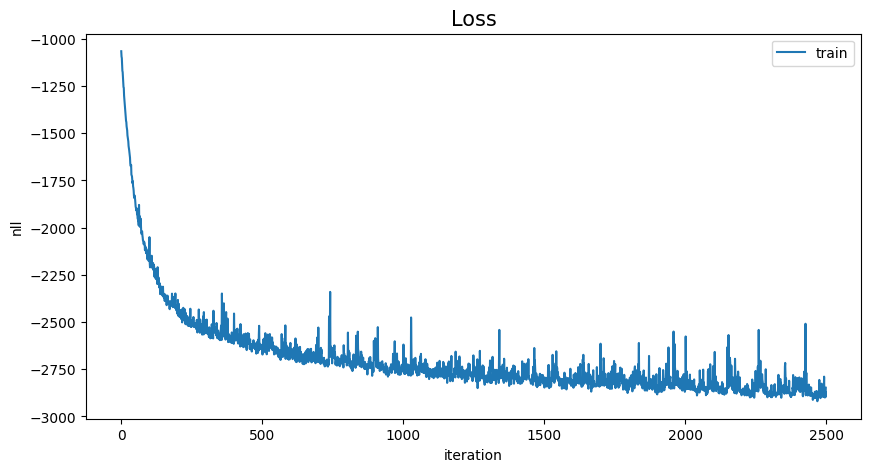

In [31]:
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

In [32]:
model.eval()

forecasts_ = []

for batch in [next(iter(test_dataloader))]:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())


In [34]:
forecasts = np.vstack(forecasts_)
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])


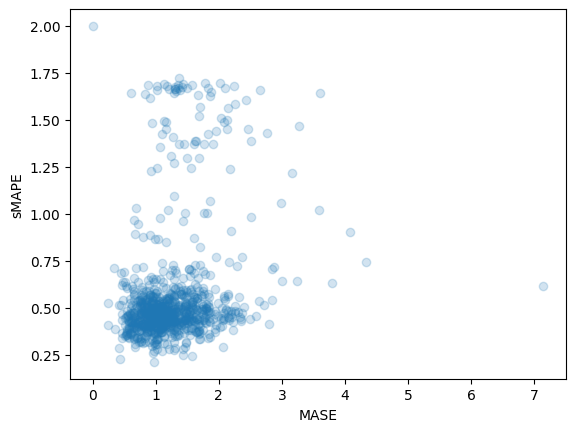

In [35]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [36]:
import matplotlib.dates as mdates


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=multi_variate_test_dataset[ts_index][FieldName.START],
        periods=len(multi_variate_test_dataset[ts_index][FieldName.TARGET]),
        freq=multi_variate_test_dataset[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        multi_variate_test_dataset[ts_index]["target"][mv_index, -2 * prediction_length :],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()


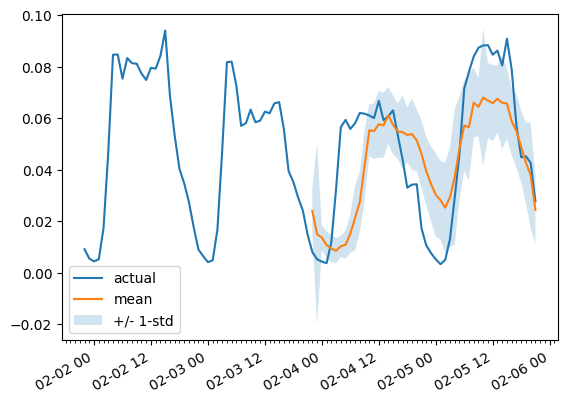

In [37]:
plot(0, 344)